In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

from backtesting import process_factors,neutralize_factors, ic_and_pnl

In [3]:
df_market = pd.read_parquet('../processed_market_data.parquet')

### 获得excess return

In [4]:
t = 'daily'
df_market[f'mkt_{t}'] = df_market.groupby('date')[f'ret_{t}'].transform('mean')
df_market[f'excess_{t}'] = df_market[f'ret_{t}'] - df_market[f'mkt_{t}']
df_market[f'excess_{t}'] = df_market.groupby('order_book_id')[f'excess_{t}'].shift(1)
df_market[f'ret_{t}_yes'] = df_market.groupby('order_book_id')[f'ret_{t}'].shift(1)

#### 风险指标计算

日内收益volatility

In [5]:
df_vol = pd.read_parquet('daily_return_vol.parquet')
df_vol['date'] = pd.to_datetime(df_vol['date'])

In [6]:
df_market = pd.merge(df_market,df_vol,left_on=['date','order_book_id'],right_on=['date','RIC'])

#### 相对风险指标计算

##### 时序比较

In [7]:
factor_list = []

In [8]:
risk_factors=['turnover_rate','ret_vol']
n=5 # 时序比较方法：比较过去5天
m=20 # rolling时间
for factor in risk_factors:
    df_market[f'{factor}_5day_avg'] = df_market.groupby(['order_book_id'])[factor].transform(lambda x: x.rolling(window=n,closed='left').mean())
    df_market[f'{factor}_re'] = df_market[f'{factor}_5day_avg'] - df_market[factor]

    for excess in ['excess_daily']:
        t = excess[7:]
        df_market[f'adj_{t}_{factor}'] = df_market[excess]*df_market[f'{factor}_re']
        df_market[f'{factor}_UMR_{t}'] = df_market.groupby('order_book_id')[f'adj_{t}_{factor}'].rolling(window=m,min_periods=m).mean().reset_index(level=0, drop=True) 
        factor_list.append(f'{factor}_UMR_{t}')


##### 中性化

In [9]:
df_industry = pd.read_parquet('../industry.parquet')
df_industry['order_book_id'] = df_industry['order_book_id'].str[:6]

df_industry = pd.merge(df_market[['order_book_id','date']], df_industry, how = 'left')
df_industry['first_industry_code'] = df_industry['first_industry_code'].ffill()
df_industry.dropna(inplace=True)

df_industry = pd.get_dummies(df_industry, columns = ['first_industry_code'],prefix='industry')
df_industry = df_industry.astype({col: 'int' for col in df_industry.columns if col.startswith('industry_')})

In [10]:
df = df_market.copy()

In [11]:
df = process_factors(df,factors= factor_list,process_method='rank')
df = neutralize_factors(df, factors= factor_list, 
       market_factor=True,momentum_factor=False, industry_factor=True, df_industry = df_industry)


df = df.drop(['industry_10', 'industry_11', 'industry_12',
       'industry_20', 'industry_21', 'industry_22', 'industry_23',
       'industry_24', 'industry_25', 'industry_26', 'industry_27',
       'industry_28', 'industry_30', 'industry_31', 'industry_32',
       'industry_33', 'industry_34', 'industry_35', 'industry_36',
       'industry_37', 'industry_40', 'industry_41', 'industry_42',
       'industry_43', 'industry_50', 'industry_60', 'industry_61',
       'industry_62', 'industry_63', 'industry_70'],axis=1)

yes,it is rank
yes,it is rank
Finish neutralize


In [16]:
df_2020 = df[df['date']>='2020-01-01']
df_2022 = df[df['date']>='2022-01-01']

### 回测

##### turnover rate

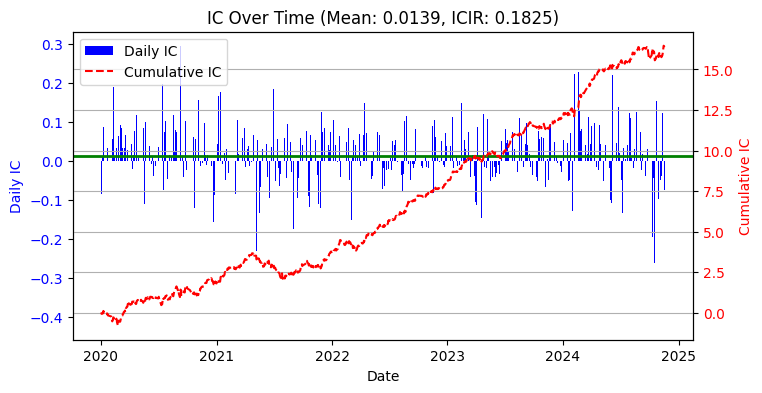

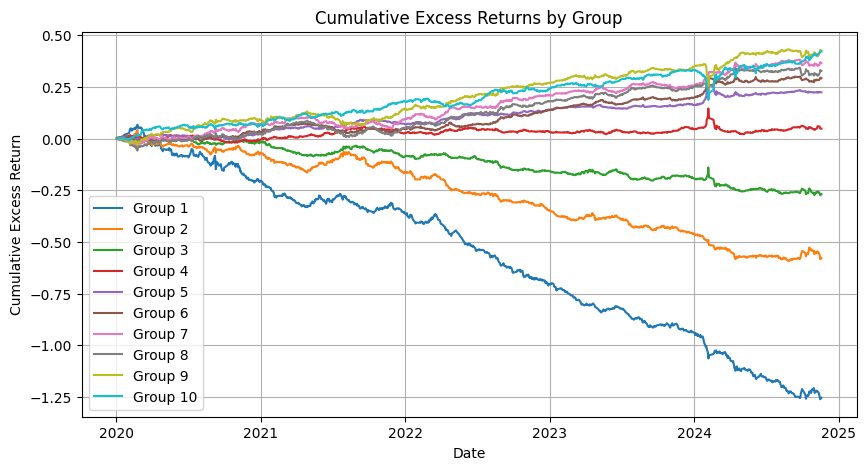

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.327585,-0.265879,-3.778930,-3.069650,0.205686
1,-0.255914,-0.122871,-4.017183,-1.929298,0.443475
2,-0.220814,-0.056996,-4.224948,-1.089900,0.546059
3,-0.173178,0.010119,-4.080803,0.237992,0.610991
4,-0.150605,0.047392,-3.872260,1.213951,0.659990
5,-0.144835,0.061814,-3.568585,1.523266,0.688828
6,-0.128644,0.077384,-2.644901,1.593857,0.686760
7,-0.123415,0.069449,-2.331783,1.317997,0.642881
8,-0.069604,0.090150,-1.123453,1.462811,0.532512


In [17]:
ic_and_pnl(df_2020,factor='neu_turnover_rate_UMR_daily_process')

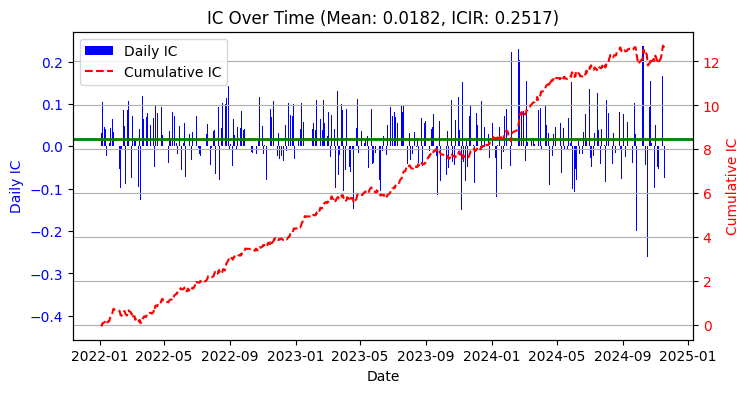

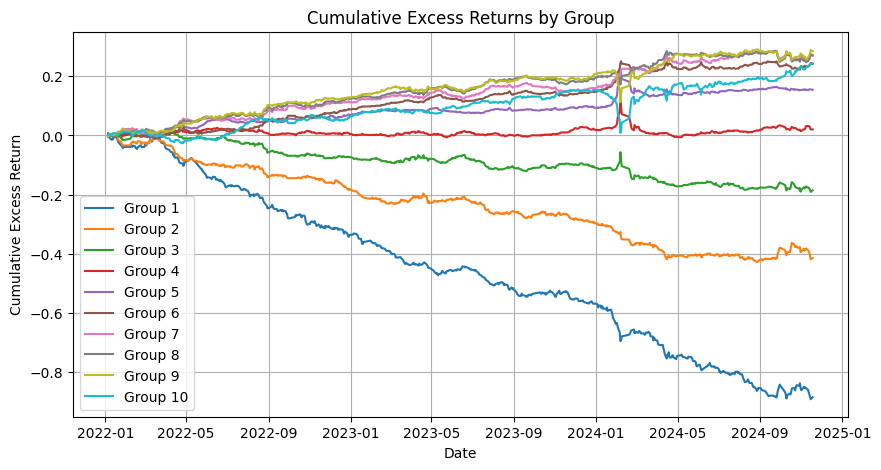

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.381601,-0.319571,-4.811958,-4.033738,0.206767
1,-0.282244,-0.149870,-4.774291,-2.531527,0.441246
2,-0.229538,-0.066881,-4.159164,-1.209570,0.542189
3,-0.174820,0.007317,-3.576637,0.149161,0.607124
4,-0.141887,0.055745,-3.124480,1.221269,0.658773
5,-0.120310,0.087346,-2.811623,2.042065,0.692186
6,-0.110649,0.097082,-2.322104,2.043385,0.692434
7,-0.097014,0.098120,-1.894757,1.932022,0.650447
8,-0.057895,0.102795,-0.890998,1.594917,0.535633


In [19]:
ic_and_pnl(df_2022,factor='neu_turnover_rate_UMR_daily_process')

##### ret vol

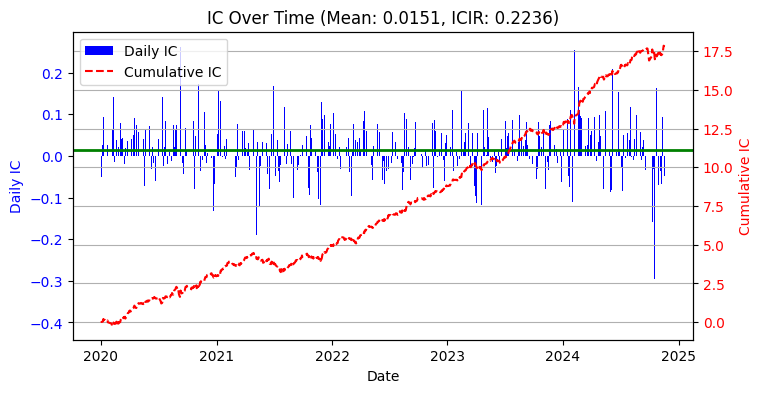

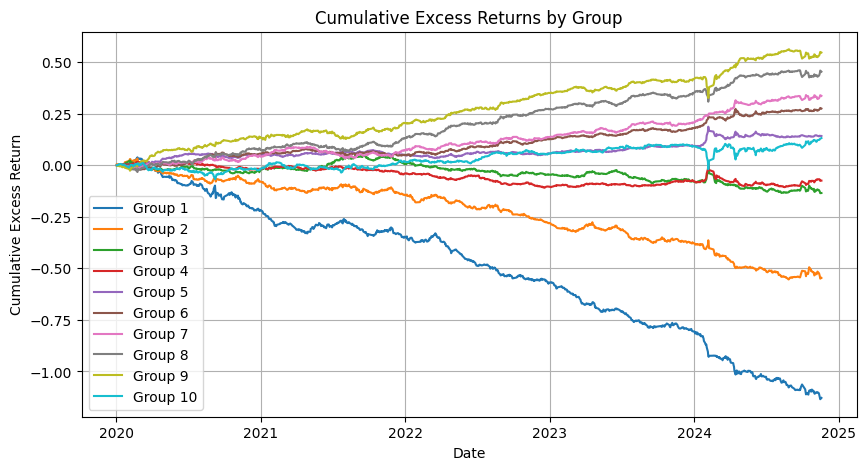

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.302831,-0.239316,-4.008183,-3.170381,0.211718
1,-0.250493,-0.115854,-4.152396,-1.919630,0.448799
2,-0.197399,-0.028579,-3.928987,-0.567628,0.562734
3,-0.209050,-0.015807,-5.230518,-0.395054,0.644143
4,-0.181569,0.030097,-5.040583,0.834680,0.705552
5,-0.165337,0.058298,-4.598539,1.624950,0.745450
6,-0.154612,0.071325,-3.668908,1.696414,0.753124
7,-0.116005,0.096191,-2.332468,1.943160,0.707319
8,-0.058774,0.115900,-0.991891,1.966138,0.582246


In [18]:
ic_and_pnl(df_2020,factor='neu_ret_vol_UMR_daily_process')

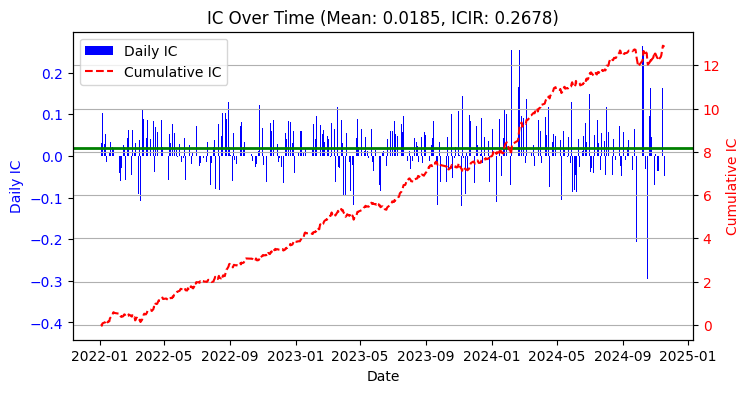

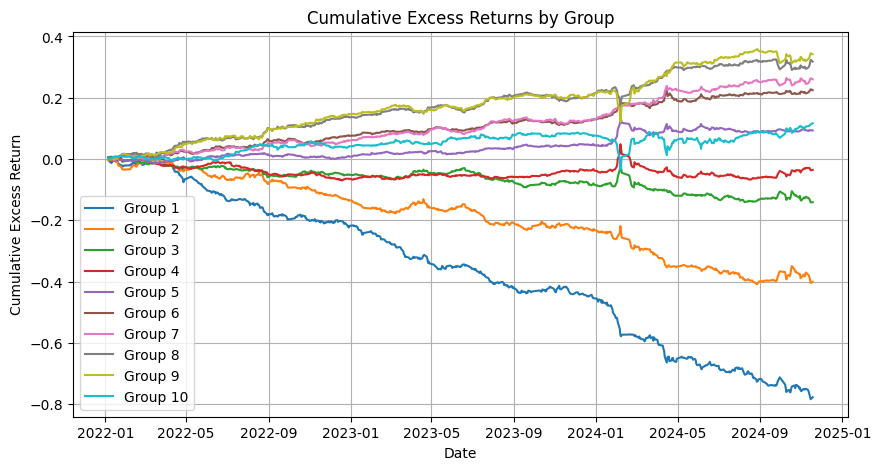

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.342430,-0.280426,-4.823657,-3.955705,0.206682
1,-0.275147,-0.144564,-4.487860,-2.355694,0.435277
2,-0.214581,-0.050753,-3.936921,-0.927727,0.546094
3,-0.201146,-0.012731,-4.387281,-0.276512,0.628049
4,-0.174740,0.033700,-4.358224,0.837280,0.694802
5,-0.141895,0.081060,-3.772176,2.158763,0.743185
6,-0.133305,0.093826,-3.212936,2.271323,0.757104
7,-0.099172,0.114837,-1.924863,2.246217,0.713363
8,-0.052573,0.123474,-0.806088,1.908561,0.586824


In [20]:
ic_and_pnl(df_2022,factor='neu_ret_vol_UMR_daily_process')